In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [48]:
fcst_us=pd.read_csv("ulsan_fcst_best_new.csv")
fcst_dj=pd.read_csv("DJ_fcst_best_new.csv")
energy=pd.read_csv('energy.csv')

In [49]:
# 시간으로 분류를해본다

energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시

# 24시를 00시로 바꿔주기
energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)



energy['year']=energy['time'].dt.year
energy['month']=energy['time'].dt.month
energy['day']=energy['time'].dt.day
energy['hour']=energy['time'].dt.hour

energy['day_int']=energy['year']*10000+energy['month']*100+energy['day']
energy['day_hour_int']=energy['day_int']*100+energy['hour']

energy


,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,date,year,month,day,hour,day_int,day_hour_int
0,2018-03-01 01:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,1,20180301,2018030101
1,2018-03-01 02:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,2,20180301,2018030102
2,2018-03-01 03:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,3,20180301,2018030103
3,2018-03-01 04:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,4,20180301,2018030104
4,2018-03-01 05:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,5,20180301,2018030105
...,...,...,...,...,...,...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,20,20210131,2021013120
25628,2021-01-31 21:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,21,20210131,2021013121
25629,2021-01-31 22:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,22,20210131,2021013122
25630,2021-01-31 23:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,23,20210131,2021013123


In [50]:
#소수점 맞춤
fcst_dj['Temperature']=round(fcst_dj['Temperature'])
fcst_us['Temperature']=round(fcst_us['Temperature'])

fcst_dj['Humidity']=round(fcst_dj['Humidity'])
fcst_us['Humidity']=round(fcst_us['Humidity'])


fcst_dj['WindSpeed']=round(fcst_dj['WindSpeed'],1)
fcst_us['WindSpeed']=round(fcst_us['WindSpeed'],1)

In [51]:
fcst_dj

,Forecast_time,Temperature,Humidity,WindSpeed,Cloud
0,2018-03-01 15:00:00,0.0,60.0,7.3,2.0
1,2018-03-01 16:00:00,-1.0,60.0,7.2,2.0
2,2018-03-01 17:00:00,-2.0,60.0,7.2,1.0
3,2018-03-01 18:00:00,-2.0,60.0,7.1,1.0
4,2018-03-01 19:00:00,-2.0,61.0,7.2,1.0
...,...,...,...,...,...
26285,2021-02-28 20:00:00,7.0,67.0,1.1,4.0
26286,2021-02-28 21:00:00,7.0,70.0,1.3,4.0
26287,2021-02-28 22:00:00,7.0,73.0,1.3,4.0
26288,2021-02-28 23:00:00,6.0,76.0,1.3,4.0


In [52]:
# 시간(hour) 변수 생성
fcst_dj['hour']= fcst_dj['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
fcst_dj['date']= fcst_dj['Forecast_time'].str.split(' ').str[0]

# year montj day추가
year_fcst = fcst_dj['date'].str.split('-').str[0].astype(int)
month_fcst = fcst_dj['date'].str.split('-').str[1].astype(int)
day_fcst = fcst_dj['date'].str.split('-').str[2].astype(int)
fcst_dj['day_int']=year_fcst*10000+month_fcst*100+day_fcst

fcst_dj['year']=year_fcst
fcst_dj['month']=month_fcst
fcst_dj['day']=day_fcst

# 정렬을 쉽게하기위한 day_hour_int를 생성
fcst_dj['day_int']=year_fcst*10000+month_fcst*100+day_fcst
fcst_dj['day_hour_int']=fcst_dj['day_int']*100+fcst_dj['hour']

In [53]:
# 시간(hour) 변수 생성
fcst_us['hour']= fcst_us['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
fcst_us['date']= fcst_us['Forecast_time'].str.split(' ').str[0]

# year montj day추가
year_fcst = fcst_us['date'].str.split('-').str[0].astype(int)
month_fcst = fcst_us['date'].str.split('-').str[1].astype(int)
day_fcst = fcst_us['date'].str.split('-').str[2].astype(int)

fcst_us['year']=year_fcst
fcst_us['month']=month_fcst
fcst_us['day']=day_fcst


# 정렬을 쉽게하기위한 day_hour_int를 생성
fcst_us['day_int']=year_fcst*10000+month_fcst*100+day_fcst
fcst_us['day_hour_int']=fcst_us['day_int']*100+fcst_us['hour']

# 변수변환

In [54]:
## 화씨 생성
fcst_dj['Temp_F']=fcst_dj['Temperature']*9/5+32
fcst_us['Temp_F']=fcst_us['Temperature']*9/5+32

## 제곱 온도 생성  &  3제곱 온도 생성
fcst_dj['Temp2']=fcst_dj['Temperature']**2
fcst_us['Temp2']=fcst_us['Temperature']**2

fcst_dj['Temp3']=fcst_dj['Temperature']**3
fcst_us['Temp3']=fcst_us['Temperature']**3


#구름 더미화
fcst_incoded_dj_1=pd.get_dummies(fcst_dj,columns=['Cloud'])
fcst_incoded_us_1=pd.get_dummies(fcst_us,columns=['Cloud'])

# 월별 더미화
fcst_incoded_dj=pd.get_dummies(fcst_incoded_dj_1,columns=['month'])
fcst_incoded_us=pd.get_dummies(fcst_incoded_us_1,columns=['month'])

# train 데이터 생성
### 평가기준에 적합한 데이터를 선정하여 train으로 전환시킨다

In [55]:
#
train_us=fcst_incoded_us[(fcst_incoded_us['day_int']<=20210131)&(fcst_incoded_us['day_int']>=20180302)]
train_us=train_us.reset_index().drop(['index'],axis=1)


train_dj=fcst_incoded_dj[(fcst_incoded_dj['day_int']<=20210131)&(fcst_incoded_dj['day_int']>=20180302)]
train_dj=train_dj.reset_index().drop(['index'],axis=1)

train_y=energy[(energy['day_int']<=20210131)&(energy['day_int']>=20180302)]
train_y=train_y.reset_index(drop=True)



In [56]:
train_us['us']=train_y.ulsan
train_us['total']=train_y.iloc[:,1:5].sum(axis=1)

train_dj['dj_or']=train_y.dangjin
train_dj['dj_wh']=train_y.dangjin_warehouse
train_dj['dj_ft']=train_y.dangjin_floating
train_dj['total']=train_y.iloc[:,1:5].sum(axis=1)

In [57]:
train_us

,Forecast_time,Temperature,Humidity,WindSpeed,hour,date,year,day,day_int,day_hour_int,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,us,total
0,2018-03-02 00:00:00,0.0,40.0,1.3,0,2018-03-02,2018,2,20180302,2018030200,...,0,0,0,0,0,0,0,0,0,0.0
1,2018-03-02 01:00:00,-1.0,42.0,1.5,1,2018-03-02,2018,2,20180302,2018030201,...,0,0,0,0,0,0,0,0,0,0.0
2,2018-03-02 02:00:00,-1.0,44.0,1.6,2,2018-03-02,2018,2,20180302,2018030202,...,0,0,0,0,0,0,0,0,0,0.0
3,2018-03-02 03:00:00,-1.0,45.0,1.8,3,2018-03-02,2018,2,20180302,2018030203,...,0,0,0,0,0,0,0,0,0,0.0
4,2018-03-02 04:00:00,-1.0,46.0,1.8,4,2018-03-02,2018,2,20180302,2018030204,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25603,2021-01-31 19:00:00,9.0,55.0,2.8,19,2021-01-31,2021,31,20210131,2021013119,...,0,0,0,0,0,0,0,0,0,0.0
25604,2021-01-31 20:00:00,9.0,58.0,3.2,20,2021-01-31,2021,31,20210131,2021013120,...,0,0,0,0,0,0,0,0,0,0.0
25605,2021-01-31 21:00:00,9.0,60.0,3.5,21,2021-01-31,2021,31,20210131,2021013121,...,0,0,0,0,0,0,0,0,0,0.0
25606,2021-01-31 22:00:00,10.0,62.0,3.9,22,2021-01-31,2021,31,20210131,2021013122,...,0,0,0,0,0,0,0,0,0,0.0


## 우선 평가기준인 total>=320을 기준으로 ulsan을 살펴보자
- dj_or & dj_ft = 1000
- dj_wh = 700
- ulsan = 500

<AxesSubplot:>

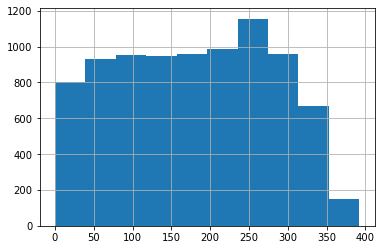

In [58]:
over_320_us=train_us[train_us['total']>=320]
over_320_us.us.hist()

In [59]:
over_320_6_us=over_320_us[over_320_us['month_6']==1][['hour','us']]
over_320_6_us['hour'].value_counts()

14    88
15    87
13    87
12    85
11    84
10    83
16    81
17    79
9     78
18    71
8     27
19     5
Name: hour, dtype: int64

In [60]:
# 19시가 평가기준에 들어온 경우의 ulsan 데이터를 살펴보자
over_320_6_us.describe()

,hour,us
count,855.000000,855.000000
mean,13.300585,181.966082
std,2.943207,98.872378
min,8.000000,0.000000
25%,11.000000,97.500000
50%,13.000000,180.000000
75%,16.000000,269.000000
max,19.000000,358.000000


In [61]:
over_320_dj=train_dj[train_dj['total']>=320]
over_320_dj.describe()

,Temperature,Humidity,WindSpeed,hour,day_int,year,day,day_hour_int,Temp_F,Temp2,...,month_7,month_8,month_9,month_10,month_11,month_12,dj_or,dj_wh,dj_ft,total
count,8506.000000,8506.000000,8506.000000,8506.000000,8.506000e+03,8506.000000,8506.000000,8.506000e+03,8506.000000,8506.000000,...,8506.000000,8506.000000,8506.000000,8506.000000,8506.000000,8506.000000,8506.000000,8491.000000,8496.000000,8506.000000
mean,16.489537,64.380555,3.741900,13.262168,2.019155e+07,2019.087703,15.821185,2.019155e+09,61.681166,362.678815,...,0.096050,0.094639,0.083000,0.087115,0.069480,0.066306,404.896544,266.189848,350.538136,1199.993887
std,9.528099,16.686814,2.305554,2.615860,8.393638e+03,0.844707,8.808292,8.393638e+05,17.150578,296.570370,...,0.294677,0.292733,0.275899,0.282020,0.254284,0.248831,199.987171,137.117310,178.573870,554.324973
min,-12.000000,8.000000,0.100000,8.000000,2.018030e+07,2018.000000,1.000000,2.018030e+09,10.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,320.000000
25%,9.000000,53.000000,2.200000,11.000000,2.018110e+07,2018.000000,8.000000,2.018110e+09,48.200000,81.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,228.000000,146.000000,193.000000,695.000000
50%,18.000000,65.000000,3.100000,13.000000,2.019072e+07,2019.000000,16.000000,2.019072e+09,64.400000,324.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,406.000000,265.000000,344.000000,1189.000000
75%,24.000000,76.000000,4.500000,15.000000,2.020043e+07,2020.000000,23.000000,2.020043e+09,75.200000,576.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,580.000000,387.000000,499.000000,1676.000000
max,35.000000,101.000000,18.100000,19.000000,2.021013e+07,2021.000000,31.000000,2.021013e+09,95.000000,1225.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,867.000000,593.000000,753.000000,2513.000000


# point!!!
흠... 원래는 total >= 320 이거나, total >= 320 이 아니더라도 각 관측소의 수용력의 10%이상의 에너지를 생성한 데이터를 추출해서 train으로 생성하려 했다 BUT total>=320의 case에서도 energy가 0일 수도 있음을 확인할 수 있다. 우리는 분석을 지역별 시간별로 하므로 모델 훈련을 위해서는capacity*0.1보다 작은 데이터도 필요하다.

### 하지만, 모든 데이터를 시간별로 사용하면 이상치나 영향력 관측치도 많다고 고려된다. (특히, 겨울의 8,19 등)

## 그래서 시간 데이터를 추출할 때 한 번이라도 평가기준에 속한 적이 있는 달에 있는 데이터만 추출한다. 이렇게 하면 처음 생각한 데이터보다는 정보 손실이 적을 것으로 예상되고, 이상치나 영향력 관측치도 덜 추출된다고 생각된다.


In [62]:
# 1월을 보자
over_320_1=over_320_us[over_320_us['month_1']==1]
over_320_1['hour'].value_counts()

14    86
13    86
15    85
12    84
11    81
16    75
10    65
17    24
Name: hour, dtype: int64

In [63]:
# 2월을 보자
over_320_2=over_320_us[over_320_us['month_2']==1]
over_320_2['hour'].value_counts()

14    54
15    53
13    52
12    52
11    51
16    50
10    46
17    44
9      8
Name: hour, dtype: int64

In [64]:
# 3월을 보자
over_320_3=over_320_us[over_320_us['month_3']==1]
over_320_3['hour'].value_counts()

13    88
12    88
11    88
15    87
14    87
16    85
10    83
17    76
9     60
18    51
Name: hour, dtype: int64

In [65]:
# 4월을 보자
over_320_4=over_320_us[over_320_us['month_4']==1]
print(over_320_4['hour'].value_counts())
over_320_4[over_320_4['hour']==8]



13    87
14    85
12    85
11    81
10    81
15    80
16    78
17    75
18    72
9     70
8      1
Name: hour, dtype: int64


,Forecast_time,Temperature,Humidity,WindSpeed,hour,date,year,day,day_int,day_hour_int,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,us,total
18680,2020-04-18 08:00:00,13.0,67.0,4.5,8,2020-04-18,2020,18,20200418,2020041808,...,0,0,0,0,0,0,0,0,67,327.0


In [66]:
# 5월을 보자
over_320_5=over_320_us[over_320_us['month_5']==1]
print(over_320_5['hour'].value_counts())

13    88
12    87
11    86
10    85
16    84
15    83
14    83
17    80
9     79
18    67
8     21
Name: hour, dtype: int64


In [67]:
# 6월을 보자
over_320_6=over_320_us[over_320_us['month_6']==1]
print(over_320_6['hour'].value_counts())
over_320_6[over_320_6['hour']==19]


14    88
15    87
13    87
12    85
11    84
10    83
16    81
17    79
9     78
18    71
8     27
19     5
Name: hour, dtype: int64


,Forecast_time,Temperature,Humidity,WindSpeed,hour,date,year,day,day_int,day_hour_int,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,us,total
2659,2018-06-20 19:00:00,22.0,78.0,2.1,19,2018-06-20,2018,20,20180620,2018062019,...,0,1,0,0,0,0,0,0,19,327.0
2683,2018-06-21 19:00:00,24.0,75.0,2.1,19,2018-06-21,2018,21,20180621,2018062119,...,0,1,0,0,0,0,0,0,18,325.0
2827,2018-06-27 19:00:00,24.0,86.0,3.2,19,2018-06-27,2018,27,20180627,2018062719,...,0,1,0,0,0,0,0,0,14,369.0
11203,2019-06-11 19:00:00,18.0,68.0,4.2,19,2019-06-11,2019,11,20190611,2019061119,...,0,1,0,0,0,0,0,0,25,323.0
11515,2019-06-24 19:00:00,20.0,78.0,2.1,19,2019-06-24,2019,24,20190624,2019062419,...,0,1,0,0,0,0,0,0,26,325.0


In [68]:
# 7월을 보자
over_320_7=over_320_us[over_320_us['month_7']==1]
print(over_320_7['hour'].value_counts())

13    89
15    86
14    85
12    85
16    84
11    82
17    81
10    77
9     67
18    66
8      8
19     7
Name: hour, dtype: int64


In [69]:
# 8월을 보자
over_320_8=over_320_us[over_320_us['month_8']==1]
print(over_320_8['hour'].value_counts())
over_320_8[over_320_8['hour']==8]


15    89
13    88
14    87
12    86
11    85
16    84
10    80
17    79
9     63
18    62
8      2
Name: hour, dtype: int64


,Forecast_time,Temperature,Humidity,WindSpeed,hour,date,year,day,day_int,day_hour_int,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,us,total
12440,2019-08-02 08:00:00,27.0,82.0,1.4,8,2019-08-02,2019,2,20190802,2019080208,...,0,0,0,1,0,0,0,0,62,321.0
12656,2019-08-11 08:00:00,27.0,89.0,2.9,8,2019-08-11,2019,11,20190811,2019081108,...,0,0,0,1,0,0,0,0,71,332.0


In [70]:
# 9월을 보자
over_320_9=over_320_us[over_320_us['month_9']==1]
print(over_320_9['hour'].value_counts())


12    84
14    83
13    81
11    81
15    78
10    76
16    72
9     63
17    61
18    27
Name: hour, dtype: int64


In [71]:
# 10월을 보자
over_320_10=over_320_us[over_320_us['month_10']==1]
print(over_320_10['hour'].value_counts())

15    88
13    88
14    87
12    86
11    86
16    84
10    83
17    70
9     69
Name: hour, dtype: int64


In [72]:
# 11월을 보자
over_320_11=over_320_us[over_320_us['month_11']==1]
print(over_320_11['hour'].value_counts())

13    84
14    81
12    81
11    81
15    76
10    74
16    71
9     39
17     4
Name: hour, dtype: int64


In [73]:
# 12월을 보자
over_320_12=over_320_us[over_320_us['month_12']==1]
print(over_320_12['hour'].value_counts())

13    88
12    85
14    84
15    83
11    82
16    72
10    68
9      2
Name: hour, dtype: int64


## 시간별 평가기준이 된 달을 출력한다.
- 8시 : 5,6,7,8 -> 4월도 1번 있으나 4월이 target도 아니고, 민규의 계절 그래프에서 4월은 나머지 달과 다르게 보였으므로 선정하지 않았다.
- 9시 : 1월에만 존재하지 않는다.
- 10시 ~ 16시 : 모든 달의 평가기준에 속한다.
- 17시 : 12월에만 존재하지 않는다.
- 18시 : 3~9월만 존재
- 19시 : 6,7월만 존재 -> 6 & 7월이 최종 평가 대상이므로 선정하여 모델을 만들 필요가 있다.

#### + 2월에는 9시~17시만 평가기준이 된다

# 새로운 train데이터를 추출하자

In [74]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [75]:
fcst_us=pd.read_csv("ulsan_fcst_best_new.csv")
fcst_dj=pd.read_csv("DJ_fcst_best_new.csv")
energy=pd.read_csv('energy.csv')

In [76]:
# 시간으로 분류를해본다

energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시

# 24시를 00시로 바꿔주기
energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)



energy['year']=energy['time'].dt.year
energy['month']=energy['time'].dt.month
energy['day']=energy['time'].dt.day
energy['hour']=energy['time'].dt.hour

energy['day_int']=energy['year']*10000+energy['month']*100+energy['day']
energy['day_hour_int']=energy['day_int']*100+energy['hour']

energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,date,year,month,day,hour,day_int,day_hour_int
0,2018-03-01 01:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,1,20180301,2018030101
1,2018-03-01 02:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,2,20180301,2018030102
2,2018-03-01 03:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,3,20180301,2018030103
3,2018-03-01 04:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,4,20180301,2018030104
4,2018-03-01 05:00:00,0.0,0.0,0,0,2018-03-01,2018,3,1,5,20180301,2018030105
...,...,...,...,...,...,...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,20,20210131,2021013120
25628,2021-01-31 21:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,21,20210131,2021013121
25629,2021-01-31 22:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,22,20210131,2021013122
25630,2021-01-31 23:00:00,0.0,0.0,0,0,2021-01-31,2021,1,31,23,20210131,2021013123


In [77]:
#소수점 맞춤
fcst_dj['Temperature']=round(fcst_dj['Temperature'])
fcst_us['Temperature']=round(fcst_us['Temperature'])

fcst_dj['Humidity']=round(fcst_dj['Humidity'])
fcst_us['Humidity']=round(fcst_us['Humidity'])


fcst_dj['WindSpeed']=round(fcst_dj['WindSpeed'],1)
fcst_us['WindSpeed']=round(fcst_us['WindSpeed'],1)

In [78]:
# 시간(hour) 변수 생성
fcst_dj['hour']= fcst_dj['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
fcst_dj['date']= fcst_dj['Forecast_time'].str.split(' ').str[0]

# year montj day추가
year_fcst = fcst_dj['date'].str.split('-').str[0].astype(int)
month_fcst = fcst_dj['date'].str.split('-').str[1].astype(int)
day_fcst = fcst_dj['date'].str.split('-').str[2].astype(int)
fcst_dj['day_int']=year_fcst*10000+month_fcst*100+day_fcst

fcst_dj['year']=year_fcst
fcst_dj['month']=month_fcst
fcst_dj['day']=day_fcst

# 정렬을 쉽게하기위한 day_hour_int를 생성
fcst_dj['day_int']=year_fcst*10000+month_fcst*100+day_fcst
fcst_dj['day_hour_int']=fcst_dj['day_int']*100+fcst_dj['hour']

In [79]:
# 시간(hour) 변수 생성
fcst_us['hour']= fcst_us['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
fcst_us['date']= fcst_us['Forecast_time'].str.split(' ').str[0]

# year montj day추가
year_fcst = fcst_us['date'].str.split('-').str[0].astype(int)
month_fcst = fcst_us['date'].str.split('-').str[1].astype(int)
day_fcst = fcst_us['date'].str.split('-').str[2].astype(int)

fcst_us['year']=year_fcst
fcst_us['month']=month_fcst
fcst_us['day']=day_fcst


# 정렬을 쉽게하기위한 day_hour_int를 생성
fcst_us['day_int']=year_fcst*10000+month_fcst*100+day_fcst
fcst_us['day_hour_int']=fcst_us['day_int']*100+fcst_us['hour']

In [80]:
### 변수 생성
## 화씨 생성
fcst_dj['Temp_F']=fcst_dj['Temperature']*9/5+32
fcst_us['Temp_F']=fcst_us['Temperature']*9/5+32

## 제곱 온도 생성  &  3제곱 온도 생성
fcst_dj['Temp2']=fcst_dj['Temperature']**2
fcst_us['Temp2']=fcst_us['Temperature']**2

fcst_dj['Temp3']=fcst_dj['Temperature']**3
fcst_us['Temp3']=fcst_us['Temperature']**3


#구름 더미화
fcst_incoded_dj_1=pd.get_dummies(fcst_dj,columns=['Cloud'])
fcst_incoded_us_1=pd.get_dummies(fcst_us,columns=['Cloud'])

# 월별 더미화
fcst_incoded_dj=pd.get_dummies(fcst_incoded_dj_1,columns=['month'])
fcst_incoded_us=pd.get_dummies(fcst_incoded_us_1,columns=['month'])

### 결합해서 데이터 생성

In [81]:
# train_X


train_us=fcst_incoded_us[(fcst_incoded_us['day_int']<=20210131)&(fcst_incoded_us['day_int']>=20180302)]
train_us=train_us.reset_index().drop(['index'],axis=1)

train_dj=fcst_incoded_dj[(fcst_incoded_dj['day_int']<=20210131)&(fcst_incoded_dj['day_int']>=20180302)]
train_dj=train_dj.reset_index().drop(['index'],axis=1)


train_dj_or=train_dj.copy()
train_dj_wh=train_dj.copy()
train_dj_ft=train_dj.copy()


#y값 추가 및 na 값 제거
train_y=energy[(energy['day_int']<=20210131)&(energy['day_int']>=20180302)]
train_y=train_y.reset_index(drop=True)


train_us['energy']=train_y.ulsan
train_us=train_us.dropna(axis=0)
train_us=train_us[train_us['energy']>0]

train_dj_or['energy']=train_y.dangjin
train_dj_or=train_dj_or.dropna(axis=0)
train_dj_or=train_dj_or[train_dj_or['energy']>0]

train_dj_wh['energy']=train_y.dangjin_warehouse
train_dj_wh=train_dj_wh.dropna(axis=0)
train_dj_wh=train_dj_wh[train_dj_wh['energy']>0]

train_dj_ft['energy']=train_y.dangjin_floating
train_dj_ft=train_dj_ft.dropna(axis=0)
train_dj_ft=train_dj_ft[train_dj_ft['energy']>0]


### ulsan_시간별 데이터 생성

In [82]:
data=train_us

#8시-> 5,6,7,8월 만
data_8=data[data['hour']==8]
data_8=data_8[(data_8['month_5']==1)|(data_8['month_6']==1)|(data_8['month_7']==1)|(data_8['month_8']==1)]

#9시 1월만 x
data_9=data[data['hour']==9]
data_9=data_9[data_9['month_1']==0]

#10시 ~ 16시 는 모든 달
data_10=data[data['hour']==10]
data_11=data[data['hour']==11]
data_12=data[data['hour']==12]
data_13=data[data['hour']==13]
data_14=data[data['hour']==14]
data_15=data[data['hour']==15]
data_16=data[data['hour']==16]

#17시는 12월만 x
data_17=data[data['hour']==17]
data_17=data_17[data_17['month_12']==0]

#18시는 3~9월만 존재
data_18=data[data['hour']==18]
data_18=data_18[(data_18['month_3']==1)|(data_18['month_4']==1)|(data_18['month_5']==1)|(data_18['month_6']==1)|(data_18['month_7']==1)|(data_18['month_8']==1)|(data_18['month_9']==1)]

#19시는 6,7만 존재
data_19=data[data['hour']==19]
data_19=data_19[(data_19['month_6']==1)|(data_19['month_7']==1)]


# 변수 추출
data_8_new=data_8[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_9_new=data_9[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_10_new=data_10[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_11_new=data_11[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_12_new=data_12[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_13_new=data_13[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_14_new=data_14[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_15_new=data_15[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_16_new=data_16[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_17_new=data_17[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_18_new=data_18[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_19_new=data_19[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]




# csv내보내기
data_8_new.to_csv("new_us_8.csv")
data_9_new.to_csv("new_us_9.csv")
data_10_new.to_csv("new_us_10.csv")
data_11_new.to_csv("new_us_11.csv")
data_12_new.to_csv("new_us_12.csv")
data_13_new.to_csv("new_us_13.csv")
data_14_new.to_csv("new_us_14.csv")
data_15_new.to_csv("new_us_15.csv")
data_16_new.to_csv("new_us_16.csv")
data_17_new.to_csv("new_us_17.csv")
data_18_new.to_csv("new_us_18.csv")
data_19_new.to_csv("new_us_19.csv")



### dJ_or 시간별 데이터 형성

In [83]:
data=train_dj_or

#8시-> 5,6,7,8월 만
data_8=data[data['hour']==8]
data_8=data_8[(data_8['month_5']==1)|(data_8['month_6']==1)|(data_8['month_7']==1)|(data_8['month_8']==1)]

#9시 1월만 x
data_9=data[data['hour']==9]
data_9=data_9[data_9['month_1']==0]

#10시 ~ 16시 는 모든 달
data_10=data[data['hour']==10]
data_11=data[data['hour']==11]
data_12=data[data['hour']==12]
data_13=data[data['hour']==13]
data_14=data[data['hour']==14]
data_15=data[data['hour']==15]
data_16=data[data['hour']==16]

#17시는 12월만 x
data_17=data[data['hour']==17]
data_17=data_17[data_17['month_12']==0]

#18시는 3~9월만 존재
data_18=data[data['hour']==18]
data_18=data_18[(data_18['month_3']==1)|(data_18['month_4']==1)|(data_18['month_5']==1)|(data_18['month_6']==1)|(data_18['month_7']==1)|(data_18['month_8']==1)|(data_18['month_9']==1)]

#19시는 6,7만 존재
data_19=data[data['hour']==19]
data_19=data_19[(data_19['month_6']==1)|(data_19['month_7']==1)]


# 변수 추출
data_8_new=data_8[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_9_new=data_9[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_10_new=data_10[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_11_new=data_11[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_12_new=data_12[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_13_new=data_13[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_14_new=data_14[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_15_new=data_15[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_16_new=data_16[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_17_new=data_17[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_18_new=data_18[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_19_new=data_19[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]




# csv내보내기
data_8_new.to_csv("new_dj_or_8.csv")
data_9_new.to_csv("new_dj_or_9.csv")
data_10_new.to_csv("new_dj_or_10.csv")
data_11_new.to_csv("new_dj_or_11.csv")
data_12_new.to_csv("new_dj_or_12.csv")
data_13_new.to_csv("new_dj_or_13.csv")
data_14_new.to_csv("new_dj_or_14.csv")
data_15_new.to_csv("new_dj_or_15.csv")
data_16_new.to_csv("new_dj_or_16.csv")
data_17_new.to_csv("new_dj_or_17.csv")
data_18_new.to_csv("new_dj_or_18.csv")
data_19_new.to_csv("new_dj_or_19.csv")



### dj_wh 시간별 데이터 생성

In [84]:
data=train_dj_wh

#8시-> 5,6,7,8월 만
data_8=data[data['hour']==8]
data_8=data_8[(data_8['month_5']==1)|(data_8['month_6']==1)|(data_8['month_7']==1)|(data_8['month_8']==1)]

#9시 1월만 x
data_9=data[data['hour']==9]
data_9=data_9[data_9['month_1']==0]

#10시 ~ 16시 는 모든 달
data_10=data[data['hour']==10]
data_11=data[data['hour']==11]
data_12=data[data['hour']==12]
data_13=data[data['hour']==13]
data_14=data[data['hour']==14]
data_15=data[data['hour']==15]
data_16=data[data['hour']==16]

#17시는 12월만 x
data_17=data[data['hour']==17]
data_17=data_17[data_17['month_12']==0]

#18시는 3~9월만 존재
data_18=data[data['hour']==18]
data_18=data_18[(data_18['month_3']==1)|(data_18['month_4']==1)|(data_18['month_5']==1)|(data_18['month_6']==1)|(data_18['month_7']==1)|(data_18['month_8']==1)|(data_18['month_9']==1)]

#19시는 6,7만 존재
data_19=data[data['hour']==19]
data_19=data_19[(data_19['month_6']==1)|(data_19['month_7']==1)]


# 변수 추출
data_8_new=data_8[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_9_new=data_9[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_10_new=data_10[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_11_new=data_11[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_12_new=data_12[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_13_new=data_13[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_14_new=data_14[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_15_new=data_15[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_16_new=data_16[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_17_new=data_17[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_18_new=data_18[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_19_new=data_19[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]




# csv내보내기
data_8_new.to_csv("new_dj_wh_8.csv")
data_9_new.to_csv("new_dj_wh_9.csv")
data_10_new.to_csv("new_dj_wh_10.csv")
data_11_new.to_csv("new_dj_wh_11.csv")
data_12_new.to_csv("new_dj_wh_12.csv")
data_13_new.to_csv("new_dj_wh_13.csv")
data_14_new.to_csv("new_dj_wh_14.csv")
data_15_new.to_csv("new_dj_wh_15.csv")
data_16_new.to_csv("new_dj_wh_16.csv")
data_17_new.to_csv("new_dj_wh_17.csv")
data_18_new.to_csv("new_dj_wh_18.csv")
data_19_new.to_csv("new_dj_wh_19.csv")



### dj_ft 시간별 데이터 형성

In [85]:
data=train_dj_ft

##8시-> 5,6,7,8월 만
data_8=data[data['hour']==8]
data_8=data_8[(data_8['month_5']==1)|(data_8['month_6']==1)|(data_8['month_7']==1)|(data_8['month_8']==1)]

#9시 1월만 x
data_9=data[data['hour']==9]
data_9=data_9[data_9['month_1']==0]

#10시 ~ 16시 는 모든 달
data_10=data[data['hour']==10]
data_11=data[data['hour']==11]
data_12=data[data['hour']==12]
data_13=data[data['hour']==13]
data_14=data[data['hour']==14]
data_15=data[data['hour']==15]
data_16=data[data['hour']==16]

#17시는 12월만 x
data_17=data[data['hour']==17]
data_17=data_17[data_17['month_12']==0]

#18시는 3~9월만 존재
data_18=data[data['hour']==18]
data_18=data_18[(data_18['month_3']==1)|(data_18['month_4']==1)|(data_18['month_5']==1)|(data_18['month_6']==1)|(data_18['month_7']==1)|(data_18['month_8']==1)|(data_18['month_9']==1)]

#19시는 6,7만 존재
data_19=data[data['hour']==19]
data_19=data_19[(data_19['month_6']==1)|(data_19['month_7']==1)]

# 변수 추출
data_8_new=data_8[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_9_new=data_9[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_10_new=data_10[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_11_new=data_11[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_12_new=data_12[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_13_new=data_13[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_14_new=data_14[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_15_new=data_15[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_16_new=data_16[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_17_new=data_17[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_18_new=data_18[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]
data_19_new=data_19[['Humidity','WindSpeed','Temperature','Temp2','Temp3','Cloud_1.0','Cloud_2.0','Cloud_3.0',
                  'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11'
                   ,'day_hour_int','hour','energy']]




# csv내보내기
data_8_new.to_csv("new_dj_ft_8.csv")
data_9_new.to_csv("new_dj_ft_9.csv")
data_10_new.to_csv("new_dj_ft_10.csv")
data_11_new.to_csv("new_dj_ft_11.csv")
data_12_new.to_csv("new_dj_ft_12.csv")
data_13_new.to_csv("new_dj_ft_13.csv")
data_14_new.to_csv("new_dj_ft_14.csv")
data_15_new.to_csv("new_dj_ft_15.csv")
data_16_new.to_csv("new_dj_ft_16.csv")
data_17_new.to_csv("new_dj_ft_17.csv")
data_18_new.to_csv("new_dj_ft_18.csv")
data_19_new.to_csv("new_dj_ft_19.csv")

